# Housing Prices: Advanced Regression Techniques

#### *Christina Papadimitriou, Takahiro Hisada, Brandon Cummings*
*W207 Final Project, Spring 2018*

## 1. Business Understanding

Many house listing web sites such as Zillow tend to focus on certain aspects of each property such as the number of bedrooms or square footage. However, there are numerous other factors involved in determing a given property's value. This competition presents 79 explanatory variables describing nearly every aspect of residential homes in Ames, Iowa challenging the participants to predict the final price of each home.

*Link to Kaggle Competition:* https://www.kaggle.com/c/house-prices-advanced-regression-techniques

*Team Name:* TheDreamTeam

## 2. Data Understanding

#### Importing Packages and Data Loading

In [60]:
# Import packages 
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.preprocessing import FunctionTransformer, StandardScaler, Imputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.kernel_ridge import KernelRidge
from sklearn.feature_extraction import FeatureHasher
from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.pyplot as plt
import math
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBClassifier, XGBRegressor
import warnings
warnings.filterwarnings('ignore')
import pandas_profiling
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNetCV
import xgboost

In [22]:
# Load the data
full_train = pd.read_csv('train.csv', squeeze=True)
test = pd.read_csv('test.csv', squeeze=True)
sample_submission = pd.read_csv('sample_submission.csv', squeeze=True)

#### Dataset Description/EDA

In [23]:
print(full_train.shape)
print(test.shape) 

(1460, 81)
(1459, 80)


The dataset (provided by Kaggle) contains 81 features (including the target variable) and 1460 observations in the train set, and 80 features (excluding the target variable) and 1459 observations in the test set. The unit of analysis in this dataset is a residential house sold in Ames, Iowa.

The target variable that we aim to predict is `SalePrice` and it represents the property's sale price in dollars. The histogram of this variable (see data profile section below), indicates that the target variable has a positively skewed distribution, and therefore, a log-transformation of this variable will be considered in order to achieve a model fit improvement. 

Additionally, the dataset includes 38 numeric and 43 categorical variables. The two sets of variables will be stored and processed separately, as different data types require different treatment. 

Lastly, the identifier variable (`Id`) is unique for each observation and will not be used as an explanatory variable in our models. 

Note: The team attempted to perform log transformations on some of the numeric variables that were heavily positively or negatively skewed, but this technique was not used in the final model since it did not improve the prediction results. 

The team used the `pandas-profiling` package to generate a detailed report that describes the dataset, including:

 * Variable data types
 * Distributions of each variable
 * Warnings based on high fractions of missing and zero values 
 * Summary statistics for numerical fields 
 * Value counts for categorical fields
 * Correlations among variables 
 
This report helped identify some anomalies in the data that will be further addressed later in the report. 

In [24]:
pandas_profiling.ProfileReport(full_train)

Number of variables,81
Number of observations,1460
Total Missing (%),5.9%
Total size in memory,924.0 KiB
Average record size in memory,648.1 B
Numeric,38
Categorical,43
Boolean,0
Date,0
Text (Unique),0
Rejected,0


In [25]:
# Storing categorical and numerical fields 
full_s_fields = ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 
                 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 
                 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 
                 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 
                 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 
                 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 
                 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 
                 'MiscFeature', 'SaleType', 'SaleCondition']

full_n_fields = ['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 
                 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 
                 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 
                 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 
                 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'YrSold', 'MoSold', 
                 'MiscVal','OverallCond', 'OverallQual', 'MSSubClass']

#### Missing Values

Below we investigate the percent of missing values per column. There are 11 columns with more than 5% of the values missing. We decide to exclude these 11 features from the dataset to improve prediction accuracy. 

In [26]:
# Find fraction of missing values per column
frac_missing = full_train.apply(lambda col: col.isnull()).sum().sort_values(ascending=False)/full_train.shape[0]
frac_missing.head(12)

PoolQC          0.995205
MiscFeature     0.963014
Alley           0.937671
Fence           0.807534
FireplaceQu     0.472603
LotFrontage     0.177397
GarageCond      0.055479
GarageType      0.055479
GarageYrBlt     0.055479
GarageFinish    0.055479
GarageQual      0.055479
BsmtExposure    0.026027
dtype: float64

In [27]:
# Store the features that will be excluded
missing_excl = list(frac_missing[frac_missing>.05].index)
missing_excl

['PoolQC',
 'MiscFeature',
 'Alley',
 'Fence',
 'FireplaceQu',
 'LotFrontage',
 'GarageCond',
 'GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageQual']

#### Columns with high percentage of Zero Values

Below we investigate the percent of zero values per column. There are 6 columns with more than 90% of their values being zero. We decide to exclude these 6 features from the dataset to improve prediction accuracy. 

In [28]:
# Find fraction of zero values per column
frac_zeros = full_train.apply(lambda col: col == 0).sum().sort_values(ascending=False)/full_train.shape[0]
frac_zeros.head(10)

PoolArea         0.995205
3SsnPorch        0.983562
LowQualFinSF     0.982192
MiscVal          0.964384
BsmtHalfBath     0.943836
ScreenPorch      0.920548
BsmtFinSF2       0.885616
EnclosedPorch    0.857534
HalfBath         0.625342
MasVnrArea       0.589726
dtype: float64

In [29]:
# Store the features that will be excluded
zeros_excl = list(frac_zeros[frac_zeros>.9].index)
zeros_excl

['PoolArea',
 '3SsnPorch',
 'LowQualFinSF',
 'MiscVal',
 'BsmtHalfBath',
 'ScreenPorch']

#### Categorical variables with highly unbalanced classes

Next, we identify categorical variables with highly unbalanced classes (i.e. almost all observations have the value of the most frequent class). We found that 11 categorical features had 90% of their observations equal to the most frequent value. We decided to exclude those features for model improvement. 

In [30]:
frac_cat = full_train[full_s_fields].apply(lambda col: col.value_counts().max()).sort_values(ascending=False)/full_train.shape[0]
frac_cat.head(10)

Utilities     0.999315
Street        0.995890
Condition2    0.989726
RoofMatl      0.982192
Heating       0.978082
LandSlope     0.946575
CentralAir    0.934932
Functional    0.931507
PavedDrive    0.917808
Electrical    0.913699
dtype: float64

In [31]:
# Store the features that will be excluded
cat_excl = list(frac_cat[frac_cat>.9].index)
cat_excl

['Utilities',
 'Street',
 'Condition2',
 'RoofMatl',
 'Heating',
 'LandSlope',
 'CentralAir',
 'Functional',
 'PavedDrive',
 'Electrical',
 'GarageCond']

#### Top/Bottom Correlations

Finally, we take a closer look at the variables that have the strongest and weakest correlations with our target variable (`SalePrice`), in order to identify variables that will most likely be strong or weak predictors of house prices. 

Some of the highly correlated variables include: overall material and finish quality (`OverallQual`), above grade (ground) living area square feet (`GrLivArea`), and size of garage in car capacity (`GarageCars`).

Most of the weak correlations that were observed, can be attributed to the fact that those variables had a high fraction of missing or zero values, and were exluded from the models anyway. Some of the weakly correlated variables that were not excluded from the models include: year sold (`YrSold`), month sold (`MoSold`) and overall condition (`OverallCond`). It is important to note that, even though these variable have small correlations with the outcome variable, `SalePrice`, when removed from the model its predictive power decreased. Therefore, they are considered to be important factors for predicting house prices. 

In [32]:
# Highest Correlation with SalePrice (Absolute Value)
full_train.corr()['SalePrice'].abs().sort_values(ascending=False).head(10)

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
Name: SalePrice, dtype: float64

In [33]:
# Lowest Correlation with SalePrice (Absolute Value)
full_train.corr()['SalePrice'].abs().sort_values(ascending=True).head(10)

BsmtFinSF2      0.011378
BsmtHalfBath    0.016844
MiscVal         0.021190
Id              0.021917
LowQualFinSF    0.025606
YrSold          0.028923
3SsnPorch       0.044584
MoSold          0.046432
OverallCond     0.077856
MSSubClass      0.084284
Name: SalePrice, dtype: float64

## 3. Data Preparation

Based on the EDA conducted in the previous section, we will now perform some feature engineering to prepare the data for the model development. 

#### Excluding Columns based on EDA

In our EDA, we have identified features that are problematic based on the below criteria:
 * Percent of missing values
 * Percent of zero values
 * Balance between classes for categorical variables

The features with high percentage of missing or zero values are not likely to be very useful for our model as they provide very little information about the house prices. Similarly, highly unbalanced categorical features, with the majority of their values being the same, are not helpful since our model would not be able to distinguish the houses based on these features and, thus, would not be able to use them in predicting house prices.

We will address the above concerns by simply excluding these variables from our dataset.

In [37]:
# excluding columns 
s_fields = [c for c in full_s_fields if not c in missing_excl and not c in zeros_excl and not c in cat_excl]
n_fields = [c for c in full_n_fields if not c in missing_excl and not c in zeros_excl]

After removing the problematic features, the number of features in our dataset has decreased from 79 to 52.

In [38]:
print("Number of features before exclusions:", len(full_s_fields) + len(full_n_fields))
print("Number of features after exclusions:", len(s_fields) + len(n_fields))

Number of features before exclusions: 79
Number of features after exclusions: 52


#### Excluding Rows that contain outliers 

In our EDA, we also came across some outliers which we want to omit from our dataset. We have decided to set the threshold for our outliers at 3 standard deviations away from the mean of the column of a given numeric feature.

In [39]:
# Remove outliers greater than 3 standard deviations
new_train = full_train.copy()
to_drop = []
for r_idx, row in full_train.iterrows():
    for c_idx, val in enumerate(row):
        c_name = full_train.columns[c_idx]
        if c_name in n_fields:
            c_mean = full_train[c_name].mean()
            val_diff = np.abs(val - c_mean)
            c_std = full_train[c_name].std()
            if val_diff >= 3 * c_std:
                to_drop.append(r_idx)

train = new_train.drop(new_train.index[to_drop])
train.shape

(1155, 81)

This leaves 1155 rows in our training dataset.

#### Defining Target and Predictors

We identify our taget feature and relevant predictors to be used in model development.

In [40]:
# Set target and predictors
target = 'SalePrice'
predictors = n_fields + s_fields

#### Log Transformation of Target Variable

One important feature transformation that the team incorporated into the modeling, was to perform a log transformation of the target variable, `SalePrice`. This transformation resulted in a significant improvement of all models. 

#### Data Processing Pipeline

In this section, we construct our data processing pipeline. First, we create separate pipelines for numeric and categorical features. 

The numeric feature pipeline includes:
1. selecting the numeric features
2. imputing the missing values using the 'mean' imputing strategy
3. standardizing the features to have a mean of 0 and a standard deviation of 1

The categorical feature pipeline includes:
1. selecting the categorical features
2. ensuring the each feature has the correct data type
3. encoding the variables as numeric using one-hot-encoding

After applying appropriate transformations to each group of features, we combine them together and conduct dimensionality reduction with PCA. The grid-search cross-validation, that will be used in the next section, yielded 191 principal components to be the best parameter choice for the PCA.

The team also attempted using a different dimensionality reduction technique, namely `TruncatedSVD`, as well as a different encoding of categorical to numeric features algorithm, namely `FeatureHasher`. Both these techniques decreased the model accuracy and therefore were not used in the final models. 

Note: some of the learning algorithms that we used are sensitive to scaling, therefore, the standardization step is crucial for model improvement.

In [55]:
def ensure_data_type(X):
    return X.apply(lambda col: col.astype(str))

def make_dictionaries(X):
    return X.to_dict(orient='records')

def select_categorical_features(X):
    return X[s_fields]

def select_numeric_features(X):
    return X[n_fields]

# Pipeline for numeric features 
numeric_feature_pipeline = Pipeline(steps=[
    ('select', FunctionTransformer(select_numeric_features, validate=False)),
    ('impute', Imputer(strategy='mean')), 
    ('scale', StandardScaler())
])

# Pipeline for categorical features 
categorical_pipeline = Pipeline(steps=[
    ('select', FunctionTransformer(select_categorical_features, validate=False)),
    ('datatype', FunctionTransformer(ensure_data_type, validate=False)),
    ('dictionaries', FunctionTransformer(make_dictionaries, validate=False)),
    ('vectorize', DictVectorizer(sparse=False)) # FeatureHasher(n_features=10)
])

# Combining the two sets of features
fu = FeatureUnion([
    ('categorical', categorical_pipeline),
    ('numeric', numeric_feature_pipeline),
])

# Dimensionality Reduction 
fr = Pipeline([
    ('union', fu),
    ('reduction', PCA(n_components=195) ),  # TruncatedSVD(n_components=400)
])

## 4. Modeling

In this section, we fit the processed data into several different models including Linear Regression with Ridge/Lasso/Elastic Net regularization, Random Forests, and Gradient Boosted Decision Trees. For each model, we  perform a grid-search cross-validation to identify the set of parameters that yield the best model (minimum error). Also, we will attempt stacking different models together in an effort to minimize the prediction error.

#### Train/Test Split

First, we split the train set into two sets: train and development. This is an important step that allows measurement of model accuracy prior to submitting our results to Kaggle, since the provided test set does not include the target variable. However, after determining the best hyper-parameters for each model and prior to submitting the predictions on Kaggle, we re-trained the model on the full train set.

In [42]:
# Train/test split
X_train_full = train[predictors]
y_train_full = train[[target]]
X_train, X_dev, y_train, y_dev = train_test_split(X_train_full, y_train_full, random_state=1)
X_test = test[predictors]

#### Useful Functions

Below we define two useful functions that were used throughout this section, namely, (1) a function to create the desired format for the prediction .csv files that were submitted on Kaggle, and (2) a function to calculate the model evaluation metric that was used in this competition (i.e. the root mean square error). 

In [43]:
# Write a prediction into a csv 
def make_csv(name, pred):
    new_df = test.copy()
    new_df['SalePrice'] = pred
    new_df[['Id', 'SalePrice']].to_csv(name, index=False)
        
def root_mean_square_error(pred, actual):
    log_actual = np.log(actual)
    log_pred = np.log(pred)
    return np.sqrt(mean_squared_error(log_actual, log_pred))

#### Ridge Regression

One of the best performing models that were developed in this analysis is the Ridge Regression. Ridge is a Linear Regression model that adds a penalty on the size of the coefficients. In our case, this model performs particularly well since the dataset contains a large number of features that could yield in overfitting. 

The grid-search cross-validation (performed below) indicated that the best parameters for the Ridge model pipeline are: `alpha=10, fit_intercept=True, solver="cholesky"`. This model resulted in an accuracy of 0.928 and a root mean square error (RMSE) of 0.008 in our development set.

In [49]:
# Gridsearch CV 
search_params = {
    'preprocess__union__numeric__impute__strategy': ['mean','median','most_frequent'],
    'preprocess__reduction__n_components': [2,20,50,100,150,191],
    'predict__alpha': [1,2,4,6,8,10],
    'predict__fit_intercept': [True, False],
    'predict__solver': ["auto", "svd", "cholesky", "lsqr", "sag"],
    'predict__random_state': [1],
}

round_num = 2
grid_search = GridSearchCV(model_pipe, search_params, cv=5)
grid_search.fit(X_train, np.log(y_train).round(round_num))
rid_pred = grid_search.predict(X_test)
print("Best Parameters:", grid_search.best_params_)
print("Score: {:.3}".format(grid_search.score(X_dev, np.log(y_dev).round(round_num))))
print("Root Mean Square Error: {:.3}".format(root_mean_square_error(grid_search.predict(X_dev), 
                                                                    np.log(y_dev).round(round_num))))

Best Parameters: {'predict__alpha': 10, 'predict__fit_intercept': True, 'predict__random_state': 1, 'predict__solver': 'sparse_cg', 'preprocess__reduction__n_components': 191, 'preprocess__union__numeric__impute__strategy': 'mean'}
Score 0.928
Root Mean Square Error: 0.00846


In [56]:
# Ridge Log Sales Price
model_pipe = Pipeline(steps=[
    ('preprocess', fr),
    ('predict', Ridge(alpha=10, fit_intercept=True, solver="cholesky"))
])

round_num = 2
model_pipe.fit(X_train, np.log(y_train).round(round_num))
print("Score: {:.3}".format(model_pipe.score(X_dev, np.log(y_dev).round(round_num))))
print("Root Mean Square Error: {:.2}".format(root_mean_square_error(model_pipe.predict(X_dev), 
                                                                    np.log(y_dev).round(round_num))))

Score: 0.928
Root Mean Square Error: 0.0084


In [57]:
# Fitting into the full train set and creating prediction file 
model_pipe.fit(X_train_full, np.log(y_train_full).round(round_num))
rid_pred = model_pipe.predict(X_test)
make_csv('Ridge.csv', np.exp(rid_pred))

** Error Analysis for Ridge Prediction **

One important step that the team took to improve the model results, was to perform an error analysis. Specifically, we examined the observations that were misclassified in order to understand what was causing the misclassifications. Our conclusion was that the misclassifications were mostly caused by outliers and weak predictors, and when those were removed from the dataset there were no extreme residuals in our model. 

Below we can see the redidual versus prediction plot, along with the actual versus prediction plot. These graphs show that there are no large residuals in our model results. 

Similar error analysis was performed for the remaining of the models, but since Ridge was overall the best single model performer, we decided to display this analysis for Ridge only. 

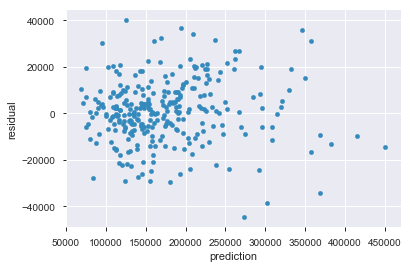

In [248]:
df = pd.DataFrame(y_dev.reset_index())
df["prediction"] = np.exp(model_pipe.predict(X_dev))
df["residual"] = df["prediction"] - df["SalePrice"]
df.plot(x="prediction",y="residual", kind='scatter')

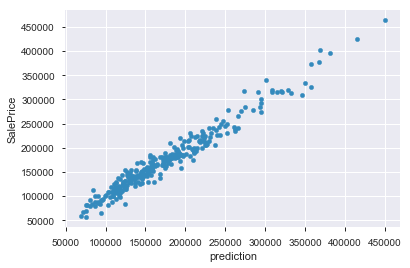

In [249]:
df = pd.DataFrame(y_dev.reset_index())
df["prediction"] = np.exp(model_pipe.predict(X_dev))
df.plot(x="prediction",y="SalePrice", kind='scatter')

#### Elastic Net Regression

The second best performing model was a Linear Regression with Elastic Net regularization. Elastic Net Regression is similar to Ridge, because it also adds a penalty on the size of the coefficients. The Elastic Net model resulted in an accuracy of 0.923 and a root mean square error (RMSE) of 0.0087 in our development set.

In [61]:
# Elastic Net Log Sales Price
model_pipe = Pipeline(steps=[
    ('preprocess', fr),
    ('predict', ElasticNetCV(l1_ratio=np.linspace(.05, .95, 20), alphas= 2. ** np.arange(-10, 10)))
])

round_num = 2
model_pipe.fit(X_train, np.log(y_train).round(round_num))
print("Score: {:.3}".format(model_pipe.score(X_dev, np.log(y_dev).round(round_num))))
print("Root Mean Square Error: {:.2}".format(root_mean_square_error(model_pipe.predict(X_dev), 
                                                                    np.log(y_dev).round(round_num))))

Score: 0.923
Root Mean Square Error: 0.0087


In [62]:
# Fitting into the full train set and creating prediction file 
model_pipe.fit(X_train_full, np.log(y_train_full).round(round_num))
EN_pred = model_pipe.predict(X_test)
make_csv('ElasticNet.csv', np.exp(EN_pred))

#### Lasso Regression

The third Linear Regression model that was used is Lasso. This model is similar to Ridge and Elastic Net, but with slightly worse predictive power in our dataset. Specifically, it yielded an accuracy of 0.919 and a root mean square error (RMSE) of 0.009 in our development set.

In [66]:
from sklearn.linear_model import LassoCV

# Lasso Log Sales Price
model_pipe = Pipeline(steps=[
    ('preprocess', fr),
    ('predict', LassoCV(alphas= 2. ** np.arange(-10, 10)))
])

round_num = 2
model_pipe.fit(X_train, np.log(y_train).round(round_num))
print("Score: {:.3}".format(model_pipe.score(X_dev, np.log(y_dev).round(round_num))))
print("Root Mean Square Error: {:.2}".format(root_mean_square_error(model_pipe.predict(X_dev), 
                                                                    np.log(y_dev).round(round_num))))

Score: 0.919
Root Mean Square Error: 0.009


In [67]:
# Fitting into the full train set and creating prediction file 
model_pipe.fit(X_train_full, np.log(y_train_full).round(round_num))
lasso_pred = model_pipe.predict(X_test)
make_csv('Lasso.csv', np.exp(lasso_pred))

#### Random Forest

Next, we use one of the most popular tree-based models: a Random Forest. The results indicated that this model performs significantly worse than the Linear Regression models mentioned above. The random forest model resulted in an accuracy of 0.862 and a root mean square error (RMSE) of 0.012 in our development set.

In [71]:
# Random Forest Log Sales Price
model_pipe = Pipeline(steps=[
    ('preprocess', fr),
    ('predict', RandomForestRegressor(n_estimators=200, oob_score=True))
])

round_num = 2
model_pipe.fit(X_train, np.log(y_train).round(round_num))
print("Score: {:.3}".format(model_pipe.score(X_dev, np.log(y_dev).round(round_num))))
print("Root Mean Square Error: {:.2}".format(root_mean_square_error(model_pipe.predict(X_dev), 
                                                                    np.log(y_dev).round(round_num))))

Score: 0.862
Root Mean Square Error: 0.012


In [70]:
# Fitting into the full train set and creating prediction file 
model_pipe.fit(X_train_full, np.log(y_train_full))
rf_pred = model_pipe.predict(X_test)
make_csv('RF.csv', np.exp(rf_pred)) 

#### Gradient Boosting

The last model that we explored and is worth mentioning is the Gradient Boosted Decision Trees. Gradient Boosting resulted in an accuracy of 0.914 and a root mean square error (RMSE) of 0.0092 in our development set.

Note: this model performs better when removing the dimensionality reduction step from the data processing pipeline. 

In [76]:
# XGB Log Sales Price
model_pipe = Pipeline(steps=[
    ('preprocess', fu),
    ('predict', XGBRegressor(n_estimators=400, max_depth=2, learning_rate=0.1,objective='reg:linear'))
])

round_num = 2
model_pipe.fit(X_train, np.log(y_train).round(round_num))
print("Score: {:.3}".format(model_pipe.score(X_dev, np.log(y_dev).round(round_num))))
print("Root Mean Square Error: {:.2}".format(root_mean_square_error(model_pipe.predict(X_dev), 
                                                                    np.log(y_dev).round(round_num))))

Score: 0.914
Root Mean Square Error: 0.0092


In [77]:
# Fitting into the full train set and creating prediction file 
model_pipe.fit(X_train_full, np.log(y_train_full))
xgb_pred = model_pipe.predict(X_test)
make_csv('xgb.csv', np.exp(xgb_pred))

#### Model Stacking 

The last step of the modeling process was to stack differerent models together and make predictions. We stacked the models by taking the average of the prediction scores obtained by each individual model. After trying different model stacking combinations, we concluded that the best stacked model was the one combining the Ridge and Elastic Net Regressions. This model was the best performer among all based on the accuracy measure on the Kaggle leaderboard. 

In [203]:
make_csv('logPrice_ridge+EN.csv',np.exp((np.reshape(rid_pred,(1459,))+EN_pred)/2))

## 5. Evaluation

This competition was measured by the root mean squared error of the estimated housing sales price, so the lower the score the better. Our initial baseline submission started at 0.18 which put us around the 50th percentile of submissions. From this moment we had attempted almost every type of model for predictions, so we realized that at this point it wasns't a secret unknown model that was going to get us the best score, but how we prepared the data for our model to fit. 

From here we started truly understanding our dataset, we performed a thorough EDA emitting columns with mostly NAs, removing numerical columns with mostly 0s, removing rows that have values that are greater than 3 standard deviations of that column's mean, logging and rounding the overall salesprice helping us generalize, and building a robust model pipeline that imputes and one-hot-encodes for PCA. The competition has ~5000 submissions, our initial score of 0.18 landed us near the 4000th rank, with our new strategy our score improved from 0.18 to .12268, jumping almost 3000 spots to the top 20%.

For every attempt, we would use GridSearchCV to find the best possible parameters, so each of the results are the absolute best attempts with our current pipeline. Our final model was a combination of two model predictions, Ridge and Elastic Net, we simply took the predictions from both and averaged them to submit on the final predictions. As for the other models attempted, here were the overall best attempts:


| Model |  Local mod.score | Local RMSE | Kaggle Score |
|------|------|------|------|
|   Ridge + Elastic Net  | ~.925 |   ~.0086  | .12268 |
|   Ridge | ~.928 |   ~.0085  | .12284 |
|   Elastic Net  | ~.923 |   ~.0087  | ~.13000 |
|   Lasso  | ~.919 |   ~.009  | ~.13000 |
|   XGBoost  | ~.914 |   ~.009  | ~.13500 |
|   RandomForest  | ~.862 |   ~.012  | ~.14500 |

Our biggest takeaway from this competition is that the first step in any of these competitions is to truly understand your data, then start attempting different models based on inference from the data. We started with the assumption the secret is a specific model, when in reality the best scores come from the combination of how you format and feature engineer the data, then understanding which type of model fits your data best.

## 6. Deployment

For deployment of this setup, we would most likely use a combination of heroku, flask, pickle, and cron jobs.

#### Heroku

Heroku is hosting service with easy to use addons and free tiers for limited usage every month. We would create a simple app with a flask structured repository. `https://www.heroku.com/`

#### Flask

Flask is a simple python web app framework that allows you to get a working web app up in minutes. We would set up one home endpoint that would load a page that contained the current models accuracy, last time it was updated, and input fields for someone to input information about a house and our service output a prediction of price and accuracy. Here is a great example from a delayed flight predictor: `https://github.com/xcitech/ml-flask-tutorial/tree/master/flask-app`

#### Pickle

Pickle is a python package that serializes your models for predictions `https://docs.python.org/2/library/pickle.html`. After fitting our model, we would save the output so we can use it for web requests:

`import pickle
 with open('logmodel.pkl', 'wb') as fid:
    pickle.dump(logmodel, fid,2) `
    
After saving this, we can now push our web app and serialized model up to heroku for people to start using.

#### Cron Jobs

We would like to have the most up-to-date and accurate model we can, so we would likely setup a cron job that runs every night that would do the following:

1) Download most recent housing data with salesprices for that day.  
2) Parse through this data, formatting it in a way our model pipeline can ingest.  
3) Run our training pipeline and re-serialize our output model.

This way, when someone visits our site to obtain predictions, we will have the most recent and updated predictions.
